In [75]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
#from scipy.ndimage import gaussian_filter1d
import sys

In [76]:
date = '20220329'
dataNo = 2
scanNo = 3

In [77]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [78]:
# param_name = 'T0046: TOF in the vertical lattice (usec.)'
param_name = 'T0005: Sweep param 5 (usec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[9]
sample3 = unique_param[19]
unit = '[us]'

In [79]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No images")

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, 'T0005: Sweep param 5 (usec.) = 200.0[us]')

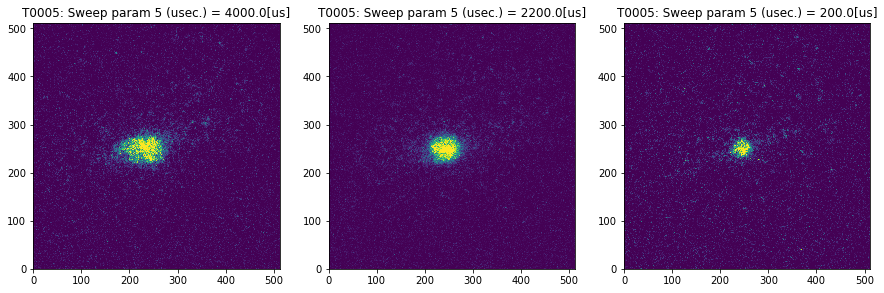

In [80]:
vmin = 0
vmax = 2000
xlim_1 = 120
xlim_2 = 320
ylim_1 = 140
ylim_2 = 340

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
# ax1.set_xlim(120,320)
# ax1.set_ylim(140,340)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
# ax2.set_xlim(120,320)
# ax2.set_ylim(140,340)
ax2.set_title(param_name+" = %.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
# ax3.set_xlim(120,320)
# ax3.set_ylim(140,340)
ax3.set_title(param_name+ " = %.01f"%(sample3)+unit)

a1= 0.009576996851788228
b1= 233.98304185027948
c1= 55.901582536720184
d= 0.0006426056893837878
$\delta$c1= 0.7423223045086537


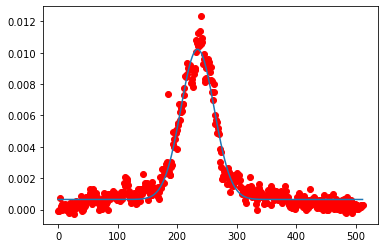

In [81]:
N=1
x_list =np.arange(np.shape(img_trans_list[0])[0])
nx=np.sum(img_trans_list[N], axis=0)/np.sum(img_trans_list[N])
ny=np.sum(img_trans_list[N], axis=1)/np.sum(img_trans_list[N])
CoMy = []
CoMx = []

for i in range(len(nx)):
    CoMx += [i*nx[i]]
for i in range(len(ny)):
    CoMy += [i*ny[i]]
CoMx = np.sum(CoMx)
CoMy = np.sum(CoMy)
para_ini=[np.max(nx), CoMx,100, np.mean(nx[0:5])]
# def nonlinear_fit(x,a1,b1,c1,d):
#     return a1*np.exp(-2*(x-b1)**2/c1**2)+d
def nonlinear_fit(x,a1,b1,c1,d):
    return a1*np.exp(-2*(x-b1)**2/c1**2)+d
# param_x, cov = scipy.optimize.curve_fit(nonlinear_fit,x_list,nx,para_x_ini)
param, cov=scipy.optimize.curve_fit(nonlinear_fit,x_list,nx,para_ini)
list_x1=x_list
list_y1=[]
for num in list_x1:
    list_y1.append(param[0]*np.exp(-2*(num-param[1])**2/param[2]**2)+param[3])

perr=np.sqrt(np.diag(cov))
print("a1=",str(param[0]))
print("b1=",str(param[1]))
print("c1=",str(param[2]))
print("d=",str(param[3]))
print(r"$\delta$c1=",str(perr[2]))
plt.scatter(x_list,nx, label='Data',c="r")
plt.plot(x_list,list_y1)

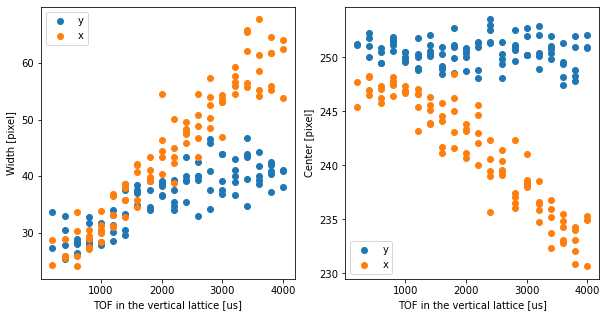

In [82]:
wx_list =[]
wy_list =[]
cx_list =[]
cy_list =[]
x_list =np.arange(np.shape(img_trans_list[0])[0])
y_list =np.arange(np.shape(img_trans_list[0])[1])
for N in range(len(trans_files)):
    nx=np.sum(img_trans_list[N], axis=0)/np.sum(img_trans_list[N])
    ny=np.sum(img_trans_list[N], axis=1)/np.sum(img_trans_list[N])
    CoMy = []
    CoMx = []
    for i in range(len(nx)):
        CoMx += [i*nx[i]]
    for i in range(len(ny)):
        CoMy += [i*ny[i]]
    CoMx = np.sum(CoMx)
    CoMy = np.sum(CoMy)
    para_x_ini = [np.max(nx), CoMx, 200, np.mean(nx[0:5])]
    # if N == 0:
    #     para_x_ini = [np.max(nx), CoMx, 200, np.mean(nx[0:5])]
    # else:
    #     para_x_ini = param_x[0:5]
    def nonlinear_fit(x,a1,b1,c1,d):
        return a1*np.exp(-2*(x-b1)**2/c1**2)+d
    param_x, cov = scipy.optimize.curve_fit(nonlinear_fit,x_list,nx,para_x_ini, maxfev=10000)
    wx_list.append(abs(param_x[2]))
    cx_list.append(param_x[1])
    para_y_ini = [np.max(ny), CoMy,20, np.mean(ny[0:5])]
    if N == 0:
        para_y_ini = [np.max(ny), CoMy,20, np.mean(ny[0:5])]
    else:
        para_y_ini = param_y[0:5]
    param_y, cov = scipy.optimize.curve_fit(nonlinear_fit,y_list,ny,para_y_ini)
    wy_list.append(abs(param_y[2]))
    cy_list.append(param_y[1])

xlabel = 'TOF in the vertical lattice [us]'

fig =plt.figure(figsize=[10,5])
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(scan_param,wy_list, label ='y')
ax1.scatter(scan_param,wx_list, label='x')
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Width [pixel]')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(scan_param,cy_list, label ='y')
ax2.scatter(scan_param,cx_list, label='x')
ax2.set_xlabel(xlabel)
ax2.set_ylabel('Center [pixel]')
ax2.legend()

In [83]:
unique_param = scan_param.unique()
centerx_list = []
centery_list = []
widthx_list = []
widthy_list = []
bec_fraction_x_list = []
bec_fraction_y_list = []
centerx_err_list = []
centery_err_list = []
widthx_err_list = []
widthy_err_list = []
for i in range(len(unique_param)):
    # print(unique_param[i])
    centerx_temp = []
    centery_temp = []
    widthx_temp = []
    widthy_temp = []
    bec_fraction_x_temp = []
    bec_fraction_y_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            # print(np.sum(img_trans_list[j][y0:y1,x0:x1])/np.sum(img_trans_list[j]))
            centerx_temp.append(cx_list[j])
            centery_temp.append(cy_list[j])
            widthx_temp.append(wx_list[j])
            widthy_temp.append(wy_list[j])
    centerx_list.append(np.mean(centerx_temp))
    centery_list.append(np.mean(centery_temp))
    widthx_list.append(np.mean(widthx_temp))
    widthy_list.append(np.mean(widthy_temp))
    centerx_err_list.append(np.std(centerx_temp))
    centery_err_list.append(np.std(centery_temp))
    widthx_err_list.append(np.std(widthx_temp))
    widthy_err_list.append(np.std(widthy_temp))

No handles with labels found to put in legend.


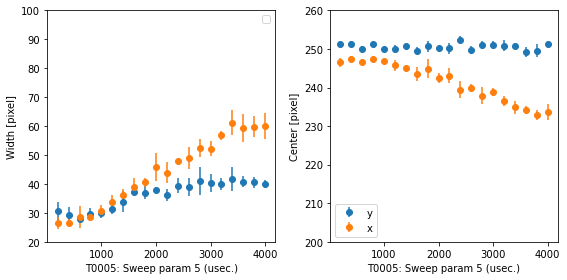

In [84]:
fig =plt.figure(figsize=[8,4])
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel('Lattice ramp up time [us]')
ax1.set_xlabel(param_name)
ax1.set_ylabel('Width [pixel]')
ax1.legend()
ax1.errorbar(unique_param,widthy_list, widthy_err_list,fmt='o',label ='y')
ax1.errorbar(unique_param,widthx_list, widthx_err_list,fmt='o',label='x')
ax1.set_ylim(20, 100)

ax2 = fig.add_subplot(1,2,2)
ax2.errorbar(unique_param,centery_list, centery_err_list, fmt='o',label ='y')
ax2.errorbar(unique_param,centerx_list, centerx_err_list,fmt='o',label='x')
ax2.set_xlabel('Lattice ramp up time [us]')
ax2.set_xlabel(param_name)
ax2.set_ylabel('Center [pixel]')
ax2.set_ylim(200, 260)
ax2.legend()

plt.tight_layout()
plt.show()

In [86]:
# results_number = 4
# full_list_of_parameters = np.array([cx_list, cy_list, wx_list, wy_list])
# averaged_parameters_list = np.full([results_number],list())
# for i in range(len(unique_param)):
#     temp_parameters_list = np.full([results_number],list())
#     for j in range(len(trans_files)):
#         if scan_param[j] == unique_param[i]:
#             for k in range(results_number):
#                 temp_parameters_list[k].append(full_list_of_parameters[k][j])
            
